# E-Mail AI Agent (Assistant)

We are creating a agent which can classify the mail into Ham or Spam:

1. If it is SPAM It will through it into SPAM folder.
2. If HAM then it will draft a e-mail and sent to the client after confirmation from the user.


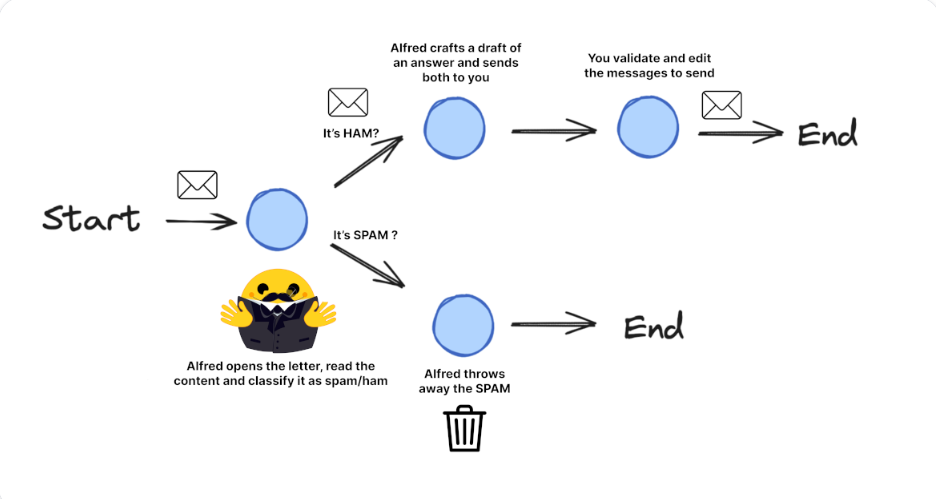

In [30]:
pip -q install langgraph

Note: you may need to restart the kernel to use updated packages.


In [31]:
# pip -q install google-ai-generativelanguage==0.6.15 --force-reinstall

In [32]:
pip -q install google-ai-generativelanguage

Note: you may need to restart the kernel to use updated packages.


### Importing necessary library

In [33]:
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

### Step 1: Define Our State

Let’s define what information Alfred needs to track during the email processing workflow:

In [34]:
class EmailState(TypedDict):
    # The e-mail being processed
    email: Dict[str,Any]

    # Category of E-Mail(Enquiry, complaint, etc)
    email_category:  Optional[str]

    # Reason why it is in spam category
    spam_reason: Optional[str]
    
    # Analysis and decision 
    is_spam: Optional[bool]
    
    # Response generator
    email_draft: Optional[str]
    
    # processing metadata
    # Track conversation with LLM for analysis
    messages: List[Dict[str,Any]]

### Step 2: Define Our Nodes
Now, let’s create the processing functions that will form our nodes

1. read_email
2. classify_email
3. handle_spam
4. draft_response
5. notify_mr_hugg

Now we will invoke LLM two times:

1. When it is a SPAM
2. When it is HAM

In [35]:
import os
# Import the correct chat model class for Google Gemini
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage

# Get the secret value for the GOOGLE API key
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
# Use the correct secret name for Gemini
gemini_api_key = user_secrets.get_secret("GOOGLE_API_KEY") 

# Set the environment variable that LangChain's ChatGoogleGenerativeAI looks for
os.environ["GOOGLE_API_KEY"] = gemini_api_key

# Initialize our LLM with the correct class and a Gemini model name
# You can choose a different Gemini model if you want
model = ChatGoogleGenerativeAI(model="gemini-1.5-flash",temperature=0)

In [36]:
# Initialize our LLM
# model = ChatOpenAI(temperature=0)

def read_email(state: EmailState):
    """Alfred reads and logs the incoming email"""
    email = state["email"]
    
    # Here we might do some initial preprocessing
    print(f"Alfred is processing an email from {email['sender']} with subject: {email['subject']}")
    
    # No state changes needed here
    return {}

def classify_email(state: EmailState):
    """Alfred uses an LLM to determine if the email is spam or legitimate"""
    email = state["email"]
    
    # Prepare our prompt for the LLM
    prompt = f"""
    As Alfred the butler, analyze this email and determine if it is spam or legitimate.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    First, determine if this email is spam. If it is spam, explain why.
    If it is legitimate, categorize it (inquiry, complaint, thank you, etc.).
    """
    
    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)
    
    # Simple logic to parse the response (in a real app, you'd want more robust parsing)
    response_text = response.content.lower()
    is_spam = "spam" in response_text and "not spam" not in response_text
    
    # Extract a reason if it's spam
    spam_reason = None
    if is_spam and "reason:" in response_text:
        spam_reason = response_text.split("reason:")[1].strip()
    
    # Determine category if legitimate
    email_category = None
    if not is_spam:
        categories = ["inquiry", "complaint", "thank you", "request", "information"]
        for category in categories:
            if category in response_text:
                email_category = category
                break
    
    # Update messages for tracking
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]
    
    # Return state updates
    return {
        "is_spam": is_spam,
        "spam_reason": spam_reason,
        "email_category": email_category,
        "messages": new_messages
    }

def handle_spam(state: EmailState):
    """Alfred discards spam email with a note"""
    print(f"Alfred has marked the email as spam. Reason: {state['spam_reason']}")
    print("The email has been moved to the spam folder.")
    
    # We're done processing this email
    return {}

def draft_response(state: EmailState):
    """Alfred drafts a preliminary response for legitimate emails"""
    email = state["email"]
    category = state["email_category"] or "general"
    
    # Prepare our prompt for the LLM
    prompt = f"""
    As Alfred the butler, draft a polite preliminary response to this email.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    This email has been categorized as: {category}
    
    Draft a brief, professional response that Mr. Hugg can review and personalize before sending.
    """
    
    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)
    
    # Update messages for tracking
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]
    
    # Return state updates
    return {
        "email_draft": response.content,
        "messages": new_messages
    }

def notify_mr_hugg(state: EmailState):
    """Alfred notifies Mr. Hugg about the email and presents the draft response"""
    email = state["email"]
    
    print("\n" + "="*50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print(f"Category: {state['email_category']}")
    print("\nI've prepared a draft response for your review:")
    print("-"*50)
    print(state["email_draft"])
    print("="*50 + "\n")
    
    # We're done processing this email
    return {}

## Step 3: Define Our Routing Logic
We need a function to determine which path to take after classification:

In [37]:
def route_email(state: EmailState) -> str:
    """Determine the next step based on spam classification"""
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"

## Step 4: Create the StateGraph and Define Edges
Now we connect everything together:

In [38]:
# Create the graph
email_graph = StateGraph(EmailState)

# Add nodes
email_graph.add_node("read_email", read_email)
email_graph.add_node("classify_email", classify_email)
email_graph.add_node("handle_spam", handle_spam)
email_graph.add_node("draft_response", draft_response)
email_graph.add_node("notify_mr_hugg", notify_mr_hugg)

# Start the edges
email_graph.add_edge(START, "read_email")
# Add edges - defining the flow
email_graph.add_edge("read_email", "classify_email")

# Add conditional branching from classify_email
email_graph.add_conditional_edges(
    "classify_email",
    route_email,
    {
        "spam": "handle_spam",
        "legitimate": "draft_response"
    }
)

# Add the final edges
email_graph.add_edge("handle_spam", END)
email_graph.add_edge("draft_response", "notify_mr_hugg")
email_graph.add_edge("notify_mr_hugg", END)

# Compile the graph
compiled_graph = email_graph.compile()

## Step 5: Run the Application
Let’s test our graph with a legitimate email and a spam email:

In [39]:
# Example legitimate email
legitimate_email = {
    "sender": "john.smith@gmail.com",
    "subject": "Question about your services",
    "body": "Dear Mr. Hugg, I was referred to you by a colleague and I'm interested in learning more about your consulting services. Could we schedule a call next week? Best regards, John Smith"
}

# Example spam email
spam_email = {
    "sender": "winner@lottery-intl.com",
    "subject": "YOU HAVE WON $5,000,000!!!",
    "body": "CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100."
}

# Process the legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})

# Process the spam email
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke({
    "email": spam_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})


Processing legitimate email...
Alfred is processing an email from john.smith@gmail.com with subject: Question about your services
Alfred has marked the email as spam. Reason: None
The email has been moved to the spam folder.

Processing spam email...
Alfred is processing an email from winner@lottery-intl.com with subject: YOU HAVE WON $5,000,000!!!
Alfred has marked the email as spam. Reason: None
The email has been moved to the spam folder.


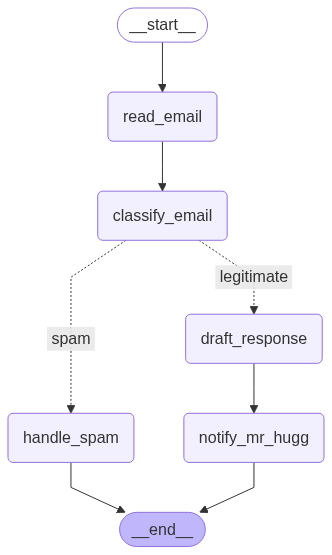

In [40]:
from IPython.display import Image, display
display(Image(compiled_graph.get_graph().draw_mermaid_png()))